In [55]:
%matplotlib inline
import sys
sys.path.insert(0,'/home/robin/Projects/sciunit')
sys.path.insert(0,'/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
sys.path.append('/home/robin/Projects/NetworkUnit')
sys.path.append('/home/robin/Projects/INM6/Tasks')
import sciunit
from networkunit import scores, models, tests, plots
from networkunit.scores import to_precision
from neo.core import SpikeTrain
from neo.io import NeoHdf5IO
from quantities import ms
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sns
import numpy as np
from simplejson import load as jsonload
from requests import get
from time import time
import os
from copy import copy
from elephant.statistics import mean_firing_rate
rc('text', usetex=True)
sns.set(style='ticks', palette='Set2', context='poster')

In [56]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Create Models

In [59]:
class microcircuit_sim_data(models.spiketrain_data):
    file_path = None
    params = {'filter_type': None,
              'filter_layer': None}
  
    def load(self, file_path, client=None, **kwargs):
        # Can load a single file or each file from directory
        # but multiple spiketrain lists can't yet be handled by tests
        if client is not None:
            client.download_file(file_path, 
                                 './sim_data/' + os.path.split(file_path)[1])
            file_path = './sim_data/' + os.path.split(file_path)[1]
        if os.path.isfile(file_path):
            dir_path, filename = os.path.split(file_path)
            file_names = [filename]
        elif os.path.isdir(file_path):
            dir_path = file_path + '/'
            file_names = []
            for name in os.listdir(file_path):
                if name.split('.')[-1] == 'h5':
                    file_names += [name]
        else:
            raise ImportError, 'No valid file path provided!'
        
        spiketrain_list = []
        for file_name in file_names:
            file_id = file_name.split('_L')[-1].split('.')[0]
            layer = file_id[:-1]
            if file_id[-1]=='E':
                ntype = 'exc'
            elif file_id[-1]=='I':
                ntype = 'inh'
            else:
                ntype = ''
            filter_layer = self.params['filter_layer']
            filter_type = self.params['filter_type']
            passed_filter = 0        
            if filter_layer is None or layer in filter_layer:
                passed_filter = 1
            if filter_type is None or filter_type == ntype:
                passed_filter *= 1
            else:
                passed_filter = 0
            
            if passed_filter:
                data = NeoHdf5IO(dir_path + file_name)
                spiketrains = data.read_block().list_children_by_class(SpikeTrain)
                for spiketrain in spiketrains[:100]:
                    spiketrain.annotate(layer='Layer {}'.format(layer))
                    spiketrain.annotate(ntype=ntype)
                    spiketrain.annotate(simulation=self.name)
                spiketrain_list += spiketrains[:100] # new spinnaker data is not yet subsampled
        return spiketrain_list


In [60]:
class NEST(microcircuit_sim_data):
    file_path = './sim_data/NEST_data/'
    params = copy(microcircuit_sim_data.params)
    color='#FF6634'

class SPIN(microcircuit_sim_data):
    file_path = './sim_data/SpiNNaker_data_after_bugfix/'
    params = copy(microcircuit_sim_data.params)
    color='#1B6145'

class SPIN_old(microcircuit_sim_data):
    file_path = './sim_data/SpiNNaker_data/'
    params = copy(microcircuit_sim_data.params)
    color=plots.alpha('#1B6145',0.4)

In [61]:
class NEST_L4I(NEST):
    params = {'filter_type': 'inh',
              'filter_layer': ['4']}

nest_l4i = NEST_L4I(name='NEST')

class SPIN_old_L4I(SPIN_old):
    params = {'filter_type': 'inh',
              'filter_layer': ['4']}

spin_old_l4i = SPIN_old_L4I(name='SpiNNaker v1')

class SPIN_L4I(SPIN):
    params = {'filter_type': 'inh',
              'filter_layer': ['4'],
              'max_subsamplesize': 100}

spin_l4i = SPIN_L4I(name='SpiNNaker v2')

### Show rasterplot

spiketrains produced


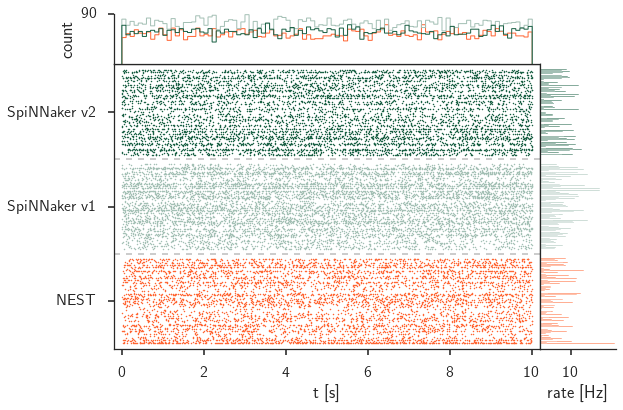

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
nest_l4i.produce_spiketrains()
spin_old_l4i.produce_spiketrains()
spin_l4i.produce_spiketrains()
print 'spiketrains produced'

palette = [nest_l4i.color, spin_old_l4i.color, spin_l4i.color]

ax, axhistx, axhisty = plots.rasterplot([nest_l4i.spiketrains, spin_old_l4i.spiketrains, spin_l4i.spiketrains],
                      ax=ax, palette=palette, context='poster', spacing = 10, groupingdepth=1, 
                      labelkey=0, pophist_mode='color', markerargs={'markersize':3,'marker':'.'}, histscale=0.15)
ax.set_yticklabels(['NEST','SpiNNaker v1', 'SpiNNaker v2'])
ax.set_xticklabels([0,0,2,4,6,8,10])
axhisty.set_xticks([0.01])
axhisty.set_xticklabels([10])
axhisty.set_xlabel('rate [Hz]')
axhistx.set_ylabel('count')
ax.set_xlabel('t [s]')

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/nest_spin_rasterplot.pdf', bbox_inches='tight')
plt.show()

# Correlation Distribution

### Show CC Samples

In [18]:
class cc_test(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.ks_distance
    params = {'binsize': 2*ms}

cctest = cc_test()

In [19]:
nest_cc = cctest.generate_prediction(model=nest_l4i)
spin_old_cc = cctest.generate_prediction(model=spin_old_l4i)
spin_cc = cctest.generate_prediction(model=spin_l4i)

mincc = min([min(nest_cc),min(spin_old_cc),min(spin_cc)])
maxcc = max([max(nest_cc),max(spin_old_cc),max(spin_cc)])

edges = np.linspace(mincc,maxcc,70)
xvalues = edges[:-1]
xvalues = xvalues + edges[1] - edges[0]

nest_hist, __ = np.histogram(nest_cc, bins=edges, density=True)
spin_old_hist, __ = np.histogram(spin_old_cc, bins=edges, density=True)
spin_hist, __ = np.histogram(spin_cc, bins=edges, density=True)

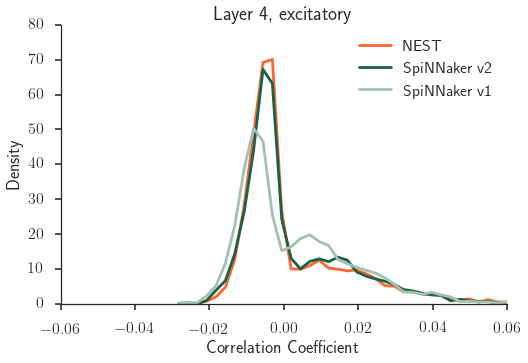

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

ax.plot(xvalues, nest_hist, color=nest_l4i.color, label='NEST')
ax.plot(xvalues, spin_hist, color=spin_l4i.color, label='SpiNNaker v2')
ax.plot(xvalues, spin_old_hist, color=spin_old_l4i.color, label='SpiNNaker v1')

ax.set_xlabel('Correlation Coefficient')
ax.set_ylabel('Density')
ax.legend()
ax.set_title('Layer 4, excitatory')
ax.set_xlim((-0.06,0.06))

sns.despine()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/nest_spin_cc_sample.pdf', bbox_inches='tight')
plt.show()

### KL Divergence

In [33]:
class kl_test(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.kl_divergence
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'cc_binsize': 0.002}

test = kl_test()

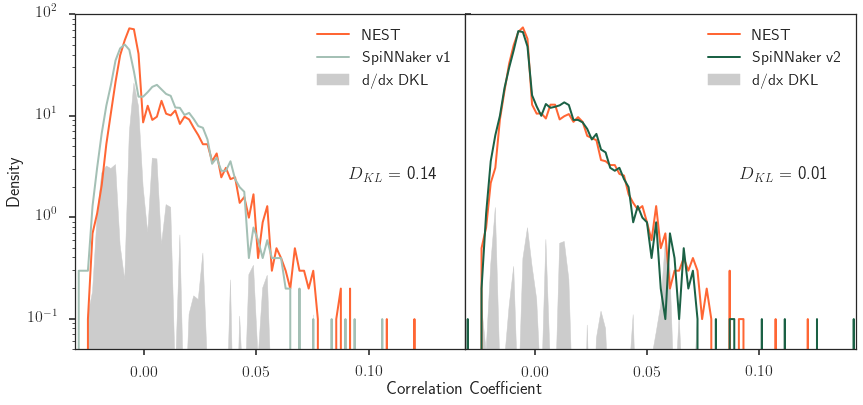

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True)
rc('text', usetex=True)

score = test.judge([nest_l4i, spin_old_l4i])
test.visualize_score(nest_l4i, spin_old_l4i, ax=ax[0], palette=[nest_l4i.color, spin_old_l4i.color])
ax[0].text(.7, .5, r'$D_{KL}$ = ' + '{}'.format(to_precision(score.iloc[0,1].score,2)),
        fontsize=18, transform=ax[0].transAxes)
ax[0].set_xlim((mincc,maxcc))
ax[0].set_ylim((0.05,100))
ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Density')
plt.tick_params(axis='x', which='both', top='off', bottom='on')
plt.tick_params(axis='y', which='both', left='on', right='on')
ax[0].xaxis.set_ticks_position('bottom')

score = test.judge([nest_l4i, spin_l4i])
test.visualize_score(nest_l4i, spin_l4i, ax=ax[1], palette=[nest_l4i.color, spin_l4i.color])
ax[1].text(.7, .5, r'$D_{KL}$ = ' + '{}'.format(to_precision(score.iloc[0,1].score,1)),
        fontsize=18, transform=ax[1].transAxes)
ax[1].set_xlim((mincc,maxcc))
ax[1].set_ylim((0.05,100))
ax[1].legend()
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.tick_params(axis='x', which='both', top='off', bottom='on')
plt.tick_params(axis='y', which='both', left='off', right='off')

fig.subplots_adjust(wspace = 0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off', labelleft='off')
plt.xticks([.5],['A'], color='w', fontsize=12)
plt.xlabel('Correlation Coefficient', fontsize=18)

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/nest_spin_kl.pdf', bbox_inches='tight')
plt.show()

### KS Distance

In [35]:
class ks_test(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.ks_distance
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms}

test = ks_test()

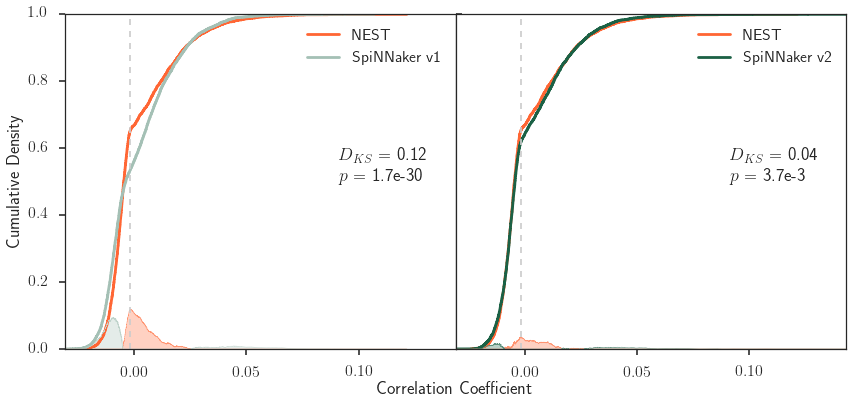

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True)
rc('text', usetex=True)

score = test.judge([nest_l4i, spin_old_l4i])
test.visualize_score(nest_l4i, spin_old_l4i, ax=ax[0], palette=[nest_l4i.color, spin_old_l4i.color])
ax[0].text(.7, .5, r'$D_{KS}$ = ' + '{}'.format(to_precision(score.iloc[0,1].score,2))
                   + '\n' + r'$p$ = {}'.format(to_precision(score.iloc[0,1].pvalue,2)),
        fontsize=18, transform=ax[0].transAxes)
ax[0].set_xlim((mincc,maxcc))
ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Cumulative Density')
plt.tick_params(axis='x', which='both', top='off', bottom='on')
plt.tick_params(axis='y', which='both', left='on', right='on')
ax[0].xaxis.set_ticks_position('bottom')

score = test.judge([nest_l4i, spin_l4i])
test.visualize_score(nest_l4i, spin_l4i, ax=ax[1], palette=[nest_l4i.color, spin_l4i.color])
ax[1].text(.7, .5, r'$D_{KS}$ = ' + '{}'.format(to_precision(score.iloc[0,1].score,1))
                   + '\n' + r'$p$ = {}'.format(to_precision(score.iloc[0,1].pvalue,2)),
        fontsize=18, transform=ax[1].transAxes)
ax[1].set_xlim((mincc,maxcc))
ax[1].legend()
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.tick_params(axis='x', which='both', top='off', bottom='on')
plt.tick_params(axis='y', which='both', left='off', right='off')

fig.subplots_adjust(wspace = 0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off', labelleft='off')
plt.xticks([.5],['A'], color='w', fontsize=12)
plt.xlabel('Correlation Coefficient', fontsize=18)

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/nest_spin_ks.pdf', bbox_inches='tight')
plt.show()

### MWU Test

In [39]:
class mwu_test(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.mwu_statistic
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms}

test = mwu_test()

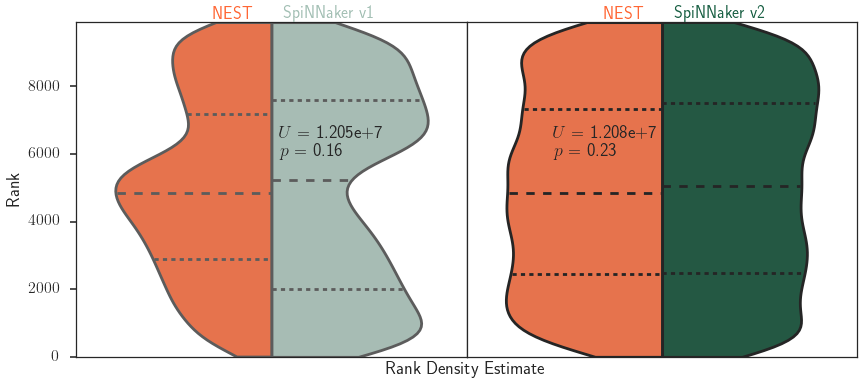

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True)
rc('text', usetex=True)

score = test.judge([nest_l4i, spin_old_l4i])
test.visualize_score(nest_l4i, spin_old_l4i, ax=ax[0], palette=[nest_l4i.color, spin_old_l4i.color])
ax[0].text(.52, .6, r'$U$ = ' + '{}'.format(to_precision(score.iloc[0,1].score,4))
                   + '\n' + r'$p$ = {}'.format(to_precision(score.iloc[0,1].pvalue,2)),
        fontsize=18, transform=ax[0].transAxes)
ax[0].set_xticks([])
ax[0].legend()
ax[0].set_xlabel('')
ax[0].set_ylabel('Rank')
plt.tick_params(axis='x', which='both', top='off', bottom='off')
plt.tick_params(axis='y', which='both', left='on', right='off')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].legend([], [], loc=9, ncol=2, handlelength=0.0, handletextpad=0.0, markerscale=0)
ax[0].text(.35, 1.01, 'NEST', fontsize=17, transform=ax[0].transAxes, color=nest_l4i.color)
ax[0].text(.53, 1.01, 'SpiNNaker v1', fontsize=17, transform=ax[0].transAxes, color=spin_old_l4i.color)

score = test.judge([nest_l4i, spin_l4i])
test.visualize_score(nest_l4i, spin_l4i, ax=ax[1], palette=[nest_l4i.color, spin_l4i.color])
ax[1].text(.22, .6, r'$U$ = ' + '{}'.format(to_precision(score.iloc[0,1].score,4))
                   + '\n' + r'$p$ = {}'.format(to_precision(score.iloc[0,1].pvalue,2)),
        fontsize=18, transform=ax[1].transAxes)
ax[1].legend()
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.tick_params(axis='x', which='both', top='off', bottom='off')
plt.tick_params(axis='y', which='both', left='off', right='off')
ax[1].legend([], [], loc=9, ncol=2, handlelength=0.0, handletextpad=0.0, markerscale=0)
ax[1].text(.35, 1.01, 'NEST', fontsize=17, transform=ax[1].transAxes, color=nest_l4i.color)
ax[1].text(.53, 1.01, 'SpiNNaker v2', fontsize=17, transform=ax[1].transAxes, color=spin_l4i.color)

fig.subplots_adjust(wspace = 0)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off', labelleft='off')
plt.xticks([],[], color='w', fontsize=2)
plt.xlabel('Rank Density Estimate', fontsize=18)

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/nest_spin_mwu.pdf', bbox_inches='tight')
plt.show()

### Effect Size

In [14]:
nest_cc = cctest.generate_prediction(model=nest_l4i)
spin_old_cc = cctest.generate_prediction(model=spin_old_l4i)
spin_cc = cctest.generate_prediction(model=spin_l4i)

NameError: name 'cctest' is not defined

In [ ]:
def s_pooled(sample1, sample2):
    n = len(sample1)
    s = np.std(sample1)
    nn = len(sample2)
    sn = np.std(sample2)
    return np.sqrt(((n-1.)*s**2 + (nn-1.)*sn**2) / (n+nn-2.))

def effect_size(sample1, sample2):
    return abs(np.mean(sample1) - np.mean(sample2)) / s_pooled(sample1, sample2)

def CI(sample1, sample2):
    n = len(sample1)
    nn = len(sample2)
    es = effect_size(sample1,sample2)
    return 1.96*np.sqrt((n+nn)/(n*nn) + es**2/(2.*(n+nn-2.)))

In [ ]:
print effect_size(nest_cc, spin_old_cc), '+-', CI(nest_cc, spin_old_cc)
print effect_size(nest_cc, spin_cc), '+-', CI(nest_cc, spin_cc)

### BEST Effect Size

In [63]:
class best_test(tests.correlation_dist_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'effect_size_type': 'mean'
             }

test_spin_old = best_test(nest_l4i)
test_spin_new = best_test(nest_l4i)

 [-----------------100%-----------------] 110000 of 110000 complete in 655.3 sec

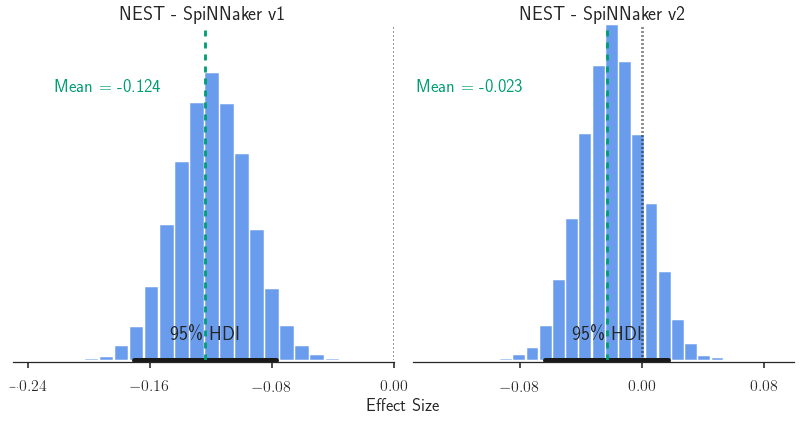

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6), sharey=True)
rc('text', usetex=True)

score_old = test_spin_old.judge(spin_old_l4i)
test_spin_old.visualize_score(spin_old_l4i, ax=ax[0])
ax[0].text(.11, .8, 'Mean = {:.3f}'.format(score_old.score),
        fontsize=18, transform=ax[0].transAxes, color='g')
ax[0].axvline(score_old.score, color='g', ls='--')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
ax[0].set_title('NEST - SpiNNaker v1')

score_new = test_spin_new.judge(spin_l4i)
test_spin_new.visualize_score(spin_l4i, ax=ax[1])
ax[1].text(.01, .8, 'Mean = {:.3f}'.format(score_new.score),
        fontsize=18, transform=ax[1].transAxes, color='g')
ax[1].axvline(score_new.score, color='g', ls='--')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('NEST - SpiNNaker v2')


fig.subplots_adjust(wspace = 0.05)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off', labelleft='off')
plt.xticks([0],['A'], color='w', fontsize=18)
plt.xlabel('Effect Size')
           
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/l4i_nest_spin_best.pdf', bbox_inches='tight')
plt.show()

# Correlation Structure

In [44]:
nest_sim = {'L23 E': NEST(filter_layer=['4'], filter_type='exc')}

In [51]:
nest_sim = NEST(filter_layer=['23','4','5','6'], filter_type=None)
spin_sim = SPIN(filter_layer=['23','4','5','6'], filter_type=None, name='SpiNNaker')

In [52]:
class struc_test(sciunit.TestM2M, tests.correlation_matrix_test):
    score_type = scores.weighted_angle
    params = {'max_subsamplesize': None,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'cluster_matrix' : False}

test = struc_test()

-0.0364842454395 1.0


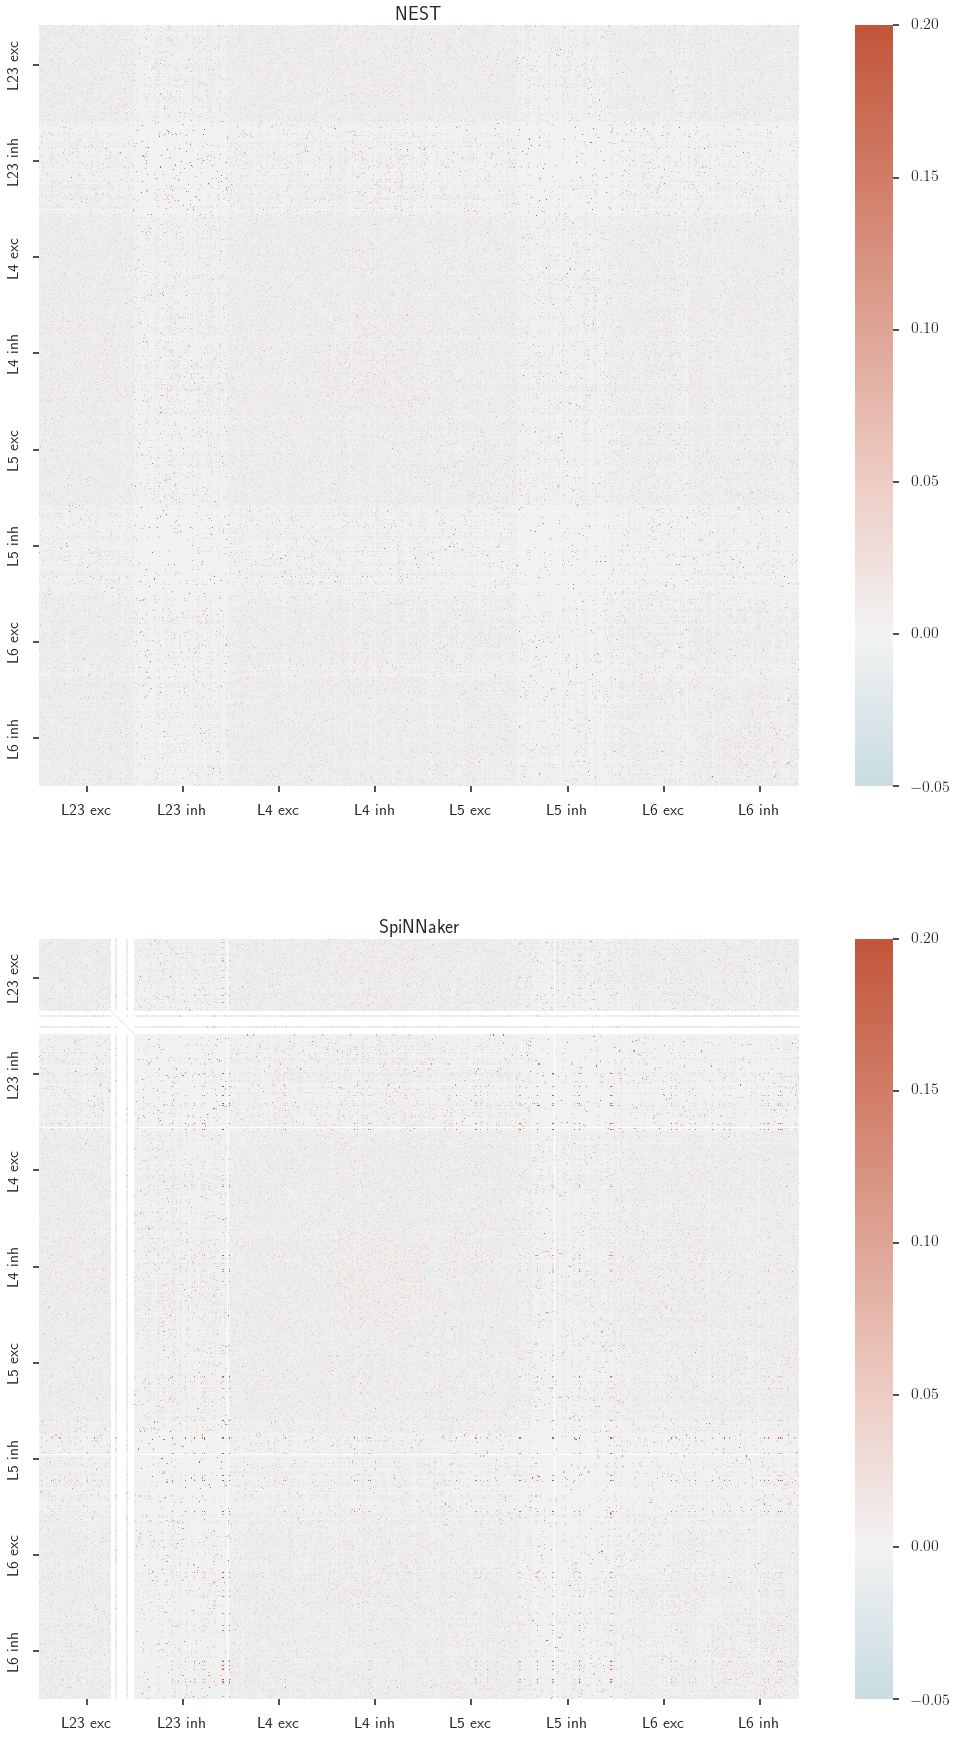

In [53]:
from matplotlib.colors import LogNorm
from matplotlib import colors
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,30))

nest_maxcc = np.nanmax(test.generate_prediction(nest_sim))
spin_maxcc = np.nanmax(test.generate_prediction(spin_sim))
vmax = np.max([nest_maxcc,spin_maxcc])
nest_mincc = np.nanmin(test.generate_prediction(nest_sim))
spin_mincc = np.nanmin(test.generate_prediction(spin_sim))
vmin = np.min([nest_mincc,spin_mincc])
print vmin, vmax
vmax=0.2
vmin=-0.05
# nest_sim.prediction[test.test_hash] = np.abs(np.nan_to_num(nest_sim.prediction[test.test_hash])) + 1.
# spin_sim.prediction[test.test_hash] = np.abs(spin_sim.prediction[test.test_hash])

# np.fill_diagonal(nest_sim.prediction[test.test_hash], 1.)

# print np.min(nest_sim.prediction[test.test_hash])

# plots.plot_correlation_matrix(nest_sim.prediction[test.test_hash][:200], ax=ax[1])#,
#                               addkwargs={'norm':LogNorm(vmin=1.)})

my_cmap = colors.LinearSegmentedColormap.from_list('my_cmap',sns.diverging_palette(220, 20, n=9)[3:])

test.visualize_samples(nest_sim, spin_sim, ax=ax, square=True, vmax=vmax, vmin=vmin, center=(vmax+vmin)/2., 
                      cmap=my_cmap)
ax[0].set_yticks([50,150,250,350,450,550,650,750])
ax[0].set_yticklabels(list(reversed(['L23 exc', 'L23 inh',
                       'L4 exc', 'L4 inh',
                       'L5 exc', 'L5 inh',
                       'L6 exc', 'L6 inh'])))
ax[0].set_xticks([50,150,250,350,450,550,650,750])
ax[0].set_xticklabels(['L23 exc', 'L23 inh',
                       'L4 exc', 'L4 inh',
                       'L5 exc', 'L5 inh',
                       'L6 exc', 'L6 inh'])
ax[1].set_yticks([50,150,250,350,450,550,650,750])
ax[1].set_yticklabels(list(reversed(['L23 exc', 'L23 inh',
                       'L4 exc', 'L4 inh',
                       'L5 exc', 'L5 inh',
                       'L6 exc', 'L6 inh'])))
ax[1].set_xticks([50,150,250,350,450,550,650,750])
ax[1].set_xticklabels(['L23 exc', 'L23 inh',
                       'L4 exc', 'L4 inh',
                       'L5 exc', 'L5 inh',
                       'L6 exc', 'L6 inh'])
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmatrix_complete.pdf'.format(layer,ntype), bbox_inches='tight')


plt.show()

In [35]:
class struc_test2(sciunit.TestM2M, tests.correlation_matrix_test):
    score_type = scores.weighted_angle
    params = {'max_subsamplesize': 100,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'cluster_matrix' : True,
              'nan_to_num' : True}
test = struc_test2()

In [38]:
def show_layer(layer, ntype='exc', sort=False, sort_alpha=0.001):
    nest_layer = NEST(filter_layer=[layer], filter_type=ntype, name='NEST L{} {}'.format(layer,ntype))
    spin_layer = SPIN(filter_layer=[layer], filter_type=ntype, name='SpiNNaker L{} {}'.format(layer,ntype))
    nest_maxcc = np.nanmax(test.generate_prediction(nest_layer))
    spin_maxcc = np.nanmax(test.generate_prediction(spin_layer))
    vmax = np.max([nest_maxcc,spin_maxcc])
    nest_mincc = np.nanmin(test.generate_prediction(nest_layer))
    spin_mincc = np.nanmin(test.generate_prediction(spin_layer))
    vmin = np.min([nest_mincc,spin_mincc])
    print vmin, vmax

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
    test.visualize_samples(nest_layer, ax=ax, square=True, vmin=vmin, vmax=vmax, cbar=False, sort=sort)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmat_nest_l{}{}.pdf'.format(layer,ntype), bbox_inches='tight')

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
    test.visualize_samples(spin_layer, ax=ax, square=True, vmin=vmin, vmax=vmax, sort=sort, sort_alpha=sort_alpha)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccmat_spin_l{}{}.pdf'.format(layer,ntype), bbox_inches='tight')

    plt.show()

-0.00793158773095 1.0


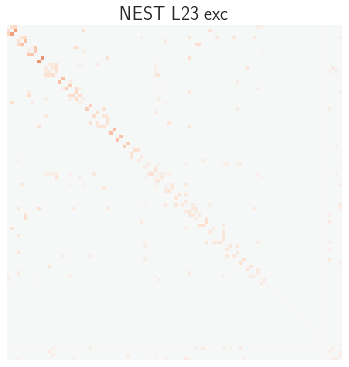

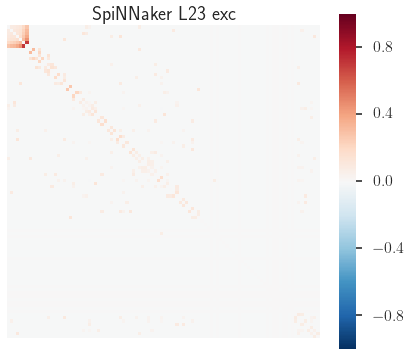

-0.0187927351853 1.0


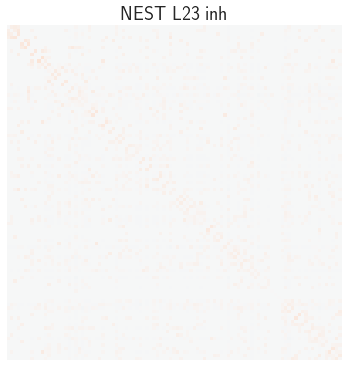

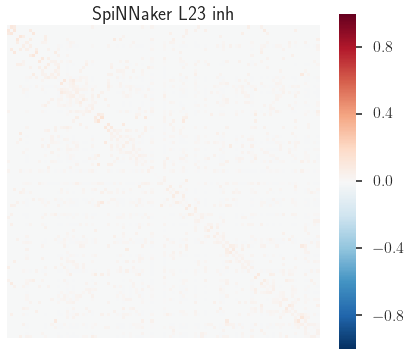

In [39]:
show_layer('23', 'exc')
show_layer('23', 'inh')

In [ ]:
# show_layer('4')
# show_layer('5')
# show_layer('6')

In [ ]:
# show_layer('23', ntype='inh')
# show_layer('4', ntype='inh')
# show_layer('5', ntype='inh')
# show_layer('6', ntype='inh')

### L23 exc distribution

In [6]:
layer = '23'
ntype = 'exc'
nest_layer = NEST(filter_layer=[layer], filter_type=ntype, 
                  name='NEST L{} {}'.format(layer,ntype), color='#FF6634')
spin_layer = SPIN(filter_layer=[layer], filter_type=ntype, 
                  name='SpiNNaker L{} {}'.format(layer,ntype), color='#1B6145')

In [7]:
class best_test(tests.correlation_dist_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'max_subsamplesize': None,
              'align_to_0' : True,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'effect_size_type': 'mean',
              'nan_to_num' : True
             }

test = best_test(nest_layer)

/home/robin/Projects/INM6/elephant/elephant/spike_train_correlation.py:247: RuntimeWarning: invalid value encountered in double_scalars
  C[i, j] = C[j, i] = enumerator / denominator


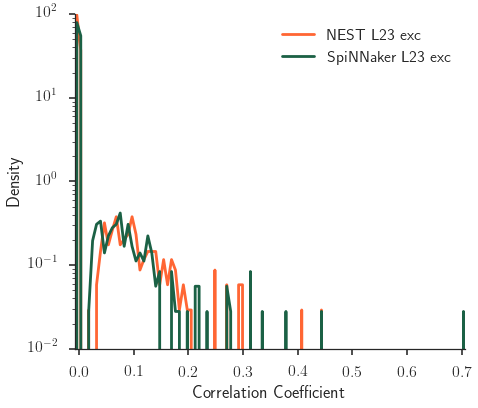

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))

nest_cc = test.generate_prediction(model=nest_layer)
spin_cc = test.generate_prediction(model=spin_layer)          

mincc = min([min(nest_cc),min(spin_cc)])
maxcc = max([max(nest_cc),max(spin_cc)])

test.visualize_samples(spin_layer, ax=ax, palette=[nest_layer.color, spin_layer.color])
ax.legend(['NEST L23 exc', 'SpiNNaker L23 exc'])
ax.set_xlim((mincc,maxcc))
ax.set_yscale('log')
ax.set_ylim((0.01,100))
ax.set_xlabel('Correlation Coefficient')
sns.despine()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/logdist_l23exc.pdf', bbox_inches='tight')

plt.show()

In [8]:
score = test.judge(spin_layer)

/usr/local/lib/python2.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 110000 of 110000 complete in 645.7 sec

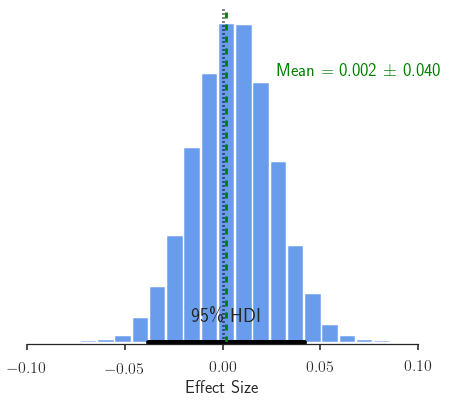

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
rc('text', usetex=True)

test.visualize_score(spin_layer, ax=ax)
ses = (score.HDI[1] - score.HDI[0])/2.
ax.text(.64, .8, 'Mean = {:.3f} '.format(score.score) + r'$\pm$' + ' {:.3f}'.format(ses), 
        fontsize=18, transform=ax.transAxes, color='g')
ax.axvline(score.score, color='g', ls='--')
ax.set_ylabel('')
           
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/best_l23exc.pdf', bbox_inches='tight')
plt.show()

# Graph Measures

### Degree Strength

In [74]:
class graph_test(tests.graph_centrality_helperclass, tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'graph_measure': 'degree strength',
              'max_subsamplesize': 98,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'nan_to_num' : True,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'assume_normal': True,
              'cluster_matrix': True,
             }

test = graph_test(nest_layer)
test.generate_prediction(nest_layer)
test.generate_prediction(spin_layer)
score = test.judge(spin_layer)

 [-----------------100%-----------------] 110000 of 110000 complete in 35.2 sec

In [75]:
print score
print max([np.abs(score.score-hde) for hde in score.HDI])



Baysian Estimation Effect Size
	datasize: 98 	 98
	Iterations: 110000 	 Burn: 10000
	Effect Size = 0.227 	 HDI = (-0.078, 0.488)


0.304821449803


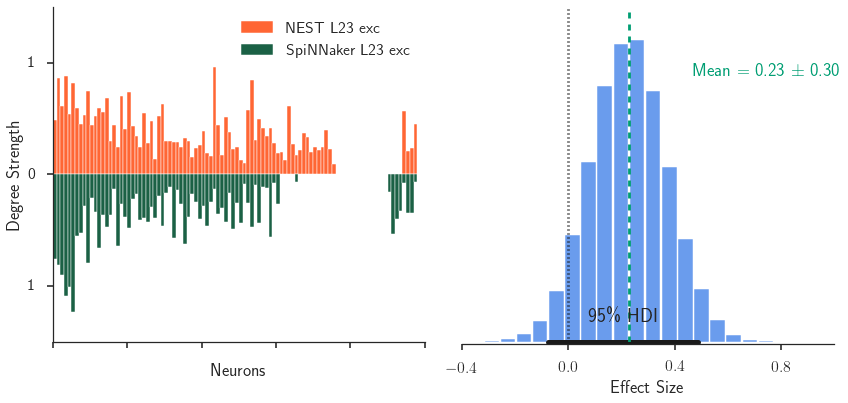

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.subplots_adjust(wspace = 0.1)

test.visualize_samples(spin_layer, ax=ax[0], palette=[nest_layer.color,spin_layer.color])
ax[0].legend(loc='best')
ax[0].set_title('')
ax[0].set_ylabel('Degree Strength')

test.visualize_score(spin_layer, ax=ax[1])
ax[1].text(.62, .8, 'Mean = {:.2f} '.format(score.score) + r'$\pm$' + ' {:.2f}'.format(max([np.abs(score.score-hde) for hde in score.HDI])), 
        fontsize=18, transform=ax[1].transAxes, color='g')
ax[1].axvline(score.score, color='g', ls='--')

ymax = np.max(np.abs(ax[0].get_ylim()))
ax[0].set_ylim((-ymax, ymax))
ax[0].set_xticklabels([])
ax[0].set_yticks([-1,0,1])
ax[0].set_yticklabels([1,0,1])


plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/l23exc_degree_strength.pdf', bbox_inches='tight')
plt.show()

### Closeness

In [79]:
class graph_test(tests.graph_centrality_helperclass, tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'graph_measure': 'closeness',
              'max_subsamplesize': 98,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'nan_to_num' : True,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'assume_normal': True,
              'cluster_matrix': True,
             }

test = graph_test(nest_layer)
test.generate_prediction(nest_layer)
test.generate_prediction(spin_layer)
score = test.judge(spin_layer)

 [-----------------100%-----------------] 110000 of 110000 complete in 33.3 sec

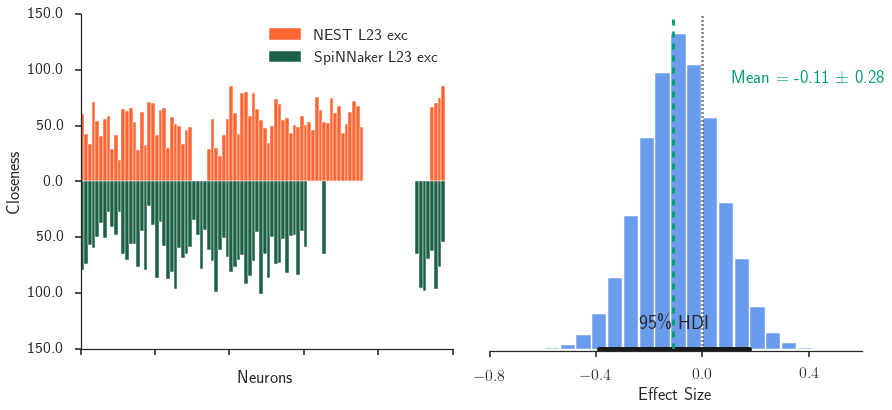

(-0.38842199585671411, 0.17458029076762072)


In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.subplots_adjust(wspace = 0.1)

test.visualize_samples(spin_layer, ax=ax[0], palette=[nest_layer.color,spin_layer.color])
ax[0].legend(loc='best')
ax[0].set_title('')
ax[0].set_ylabel('Closeness')

test.visualize_score(spin_layer, ax=ax[1])
ax[1].text(.65, .8, 'Mean = {:.2f} '.format(score.score) + r'$\pm$' + ' {:.2f}'.format(max([np.abs(score.score-hde) for hde in score.HDI])), 
        fontsize=18, transform=ax[1].transAxes, color='g')
ax[1].axvline(score.score, color='g', ls='--')

ymax = np.max(np.abs(ax[0].get_ylim()))
ax[0].set_ylim((-ymax, ymax))
ax[0].set_xticklabels([])

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/l23exc_closeness.pdf', bbox_inches='tight')
plt.show()
print score.HDI

### Betweenness

In [81]:
class graph_test(tests.graph_centrality_helperclass, tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'graph_measure': 'betweenness',
              'max_subsamplesize': 98,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'nan_to_num' : True,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'assume_normal': True,
              'cluster_matrix': True,
             }

test = graph_test(nest_layer)
test.generate_prediction(nest_layer)
test.generate_prediction(spin_layer)
score = test.judge(spin_layer)

 [-----------------100%-----------------] 110000 of 110000 complete in 32.1 sec

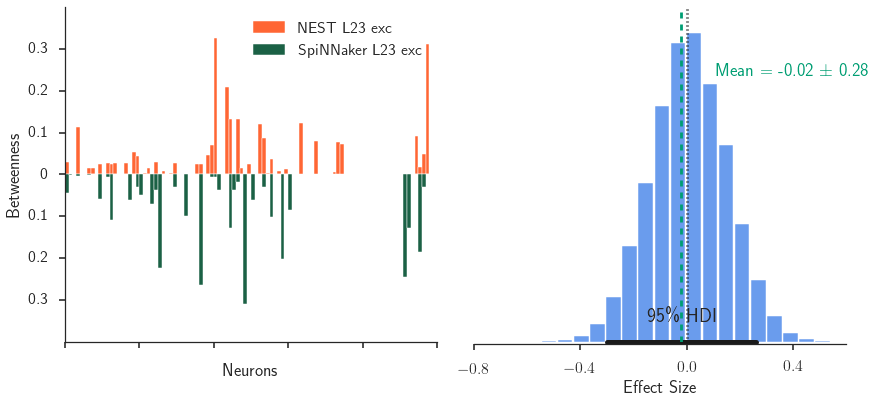

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.subplots_adjust(wspace = 0.1)

test.visualize_samples(spin_layer, ax=ax[0], palette=[nest_layer.color,spin_layer.color])
ax[0].legend(loc='best')
ax[0].set_title('')
ax[0].set_ylabel('Betweenness')

test.visualize_score(spin_layer, ax=ax[1])
ax[1].text(.65, .8, 'Mean = {:.2f} '.format(score.score) + r'$\pm$' + ' {:.2f}'.format(max([np.abs(score.score-hde) for hde in score.HDI])), 
        fontsize=18, transform=ax[1].transAxes, color='g')
ax[1].axvline(score.score, color='g', ls='--')

ymax = np.max(np.abs(ax[0].get_ylim()))
ax[0].set_ylim((-ymax, ymax))
ax[0].set_xticklabels([])
ax[0].set_yticks([-0.3,-0.2, -0.1,0,0.1,0.2,0.3])
ax[0].set_yticklabels([0.3,0.2,0.1,0,0.1,0.2,0.3])

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/l23exc_betweenness.pdf', bbox_inches='tight')
plt.show()

### Clustering Coefficient

In [87]:
class graph_test(tests.graph_centrality_helperclass, tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'graph_measure': 'clustering coefficient',
              'max_subsamplesize': 98,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'nan_to_num' : True,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'assume_normal': True,
              'cluster_matrix': True,
             }

test = graph_test(nest_layer)
test.generate_prediction(nest_layer)
test.generate_prediction(spin_layer)
score = test.judge(spin_layer)

 [-----------------100%-----------------] 110000 of 110000 complete in 35.9 sec

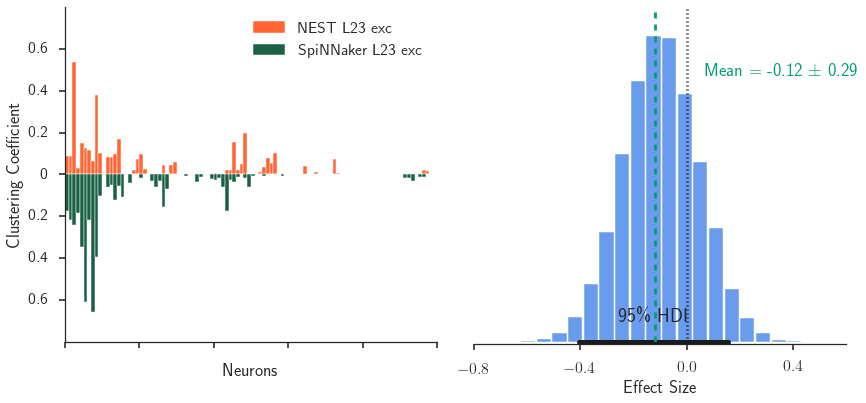

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
fig.subplots_adjust(wspace = 0.1)

test.visualize_samples(spin_layer, ax=ax[0], palette=[nest_layer.color,spin_layer.color])
ax[0].legend(loc='best')
ax[0].set_title('')
ax[0].set_ylabel('Clustering Coefficient')

test.visualize_score(spin_layer, ax=ax[1])
ax[1].text(.62, .8, 'Mean = {:.2f} '.format(score.score) + r'$\pm$' + ' {:.2f}'.format(max([np.abs(score.score-hde) for hde in score.HDI])), 
        fontsize=18, transform=ax[1].transAxes, color='g')
ax[1].axvline(score.score, color='g', ls='--')

ymax = np.max(np.abs(ax[0].get_ylim()))
ax[0].set_ylim((-ymax, ymax))
ax[0].set_xticklabels([])
ax[0].set_yticks([-0.6,-0.4, -0.2,0,0.2,0.4,0.6])
ax[0].set_yticklabels([0.6,0.4,0.2,0,0.2,0.4,0.6])

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/l23exc_clustering_coefficient.pdf', bbox_inches='tight')
plt.show()

### Transitivity

In [10]:
class graph_test(tests.graph_centrality_helperclass, tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'graph_measure': 'transitivity',
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'bin_num': 5000,
              'nan_to_num' : True,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'cluster_matrix': True,
             }

test = graph_test(nest_layer)
t_nest = test.generate_prediction(nest_layer)
t_spin = test.generate_prediction(spin_layer)

In [11]:
print t_nest, t_spin

0.160344827586 0.248185776488


### Small-World Index

In [14]:
class graph_test(tests.graph_centrality_helperclass, tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.best_effect_size
    params = {'graph_measure': 'small-worldness',
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'edge_threshold' : 0.,
              'nan_to_num' : True,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'cluster_matrix': True,
             }

test = graph_test(nest_layer)
t_nest = test.generate_prediction(nest_layer)
t_spin = test.generate_prediction(spin_layer)

NetworkXError: Graph is not connected.

In [ ]:
print t_nest, t_spin

# Eigenvector Angles

In [21]:
layer = '23'
ntype = 'exc'
nest_layer = NEST(filter_layer=[layer], filter_type=ntype, 
                  name='NEST L{} {}'.format(layer,ntype), color='#FF6634')
spin_layer = SPIN(filter_layer=[layer], filter_type=ntype, 
                  name='SpiNNaker L{} {}'.format(layer,ntype), color='#1B6145')

In [28]:
class angle_test(sciunit.TestM2M, tests.correlation_matrix_test):
    score_type = scores.weighted_angle
    params = {'max_subsamplesize': 98,
              'binsize' : 2 * ms,
              't_start' : 0 * ms,
              't_stop' : 10000 * ms,
              'bin_num': 5000,
              'nan_to_num' : True,
              'mcmc_iter' : 110000,
              'mcmc_burn' : 10000,
              'cluster_matrix': True,
              'all_to_all': False,
             }
    def compute_score(self, observation, prediction):
        score = self.score_type.compute(observation, prediction, **self.params)
        return score

test = angle_test()

In [29]:
score = test.judge([nest_layer, spin_layer])
print score.score
print score.iloc[0,1].pvalue

                   NEST L23 exc  SpiNNaker L23 exc
NEST L23 exc           1.000000           0.012692
SpiNNaker L23 exc      0.012692           1.000000
0.0520095324151


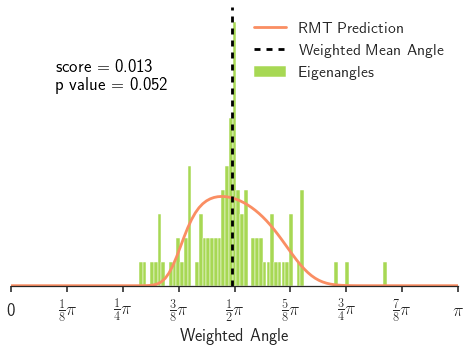

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
test.visualize_score(nest_layer, spin_layer, bin_num=5000, ax=ax, 
                     palette=[sns.color_palette('Set2')[1], sns.color_palette('Set2')[4]])
ax.text(.1, .7, 'score = {:.3f} \n p value = {:.3f} '.format(score.iloc[0,1].score, score.iloc[0,1].pvalue), 
        fontsize=18, transform=ax.transAxes, color='k')
plt.legend(['RMT Prediction', 'Weighted Mean Angle', 'Eigenangles'])
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/l23exc_weighted_angle_{}.pdf'\
            .format('all_to_all' if angle_test.params['all_to_all'] else 'one_to_one'), bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)
